# ICT606 Machine Learning
## Assignment 2
## COVID-19 All Vaccines Tweets

#### **Library & Data Import**
****

In [1]:
# PLEASE INSTALL/DOWNLOAD BEFORE RUNNING IF MISSING PACKAGE
# !pip install bertopic
# !pip install gensim

# library 
import os # file & folder management 
import pandas as pd # general library for data manipulation
import numpy as np # general library for numerical computation 
import matplotlib.pyplot as plt # data visualisation charts
import seaborn as sns # data visualisation charts
import re # support pattern matching and text manipulation
import nltk # library for processing NLP 
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

from wordcloud import WordCloud # word cloud
from nltk.corpus import stopwords # stop word
from nltk.stem import WordNetLemmatizer # lemmatization
from sklearn.feature_extraction.text import CountVectorizer # general library for various data science utility
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic import BERTopic # BERTopic Modelling 
from umap import UMAP # reduce dimensionality 
from gensim.models.coherencemodel import CoherenceModel # topic extraction & similarity calculation
from gensim.corpora import Dictionary # topic extraction & similarity calculation



In [2]:
df = pd.read_csv("vaccination_all_tweets.csv")
df.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [3]:
dfdesc = pd.DataFrame(df.describe(include = 'all').transpose())

def summary_stats(df): 
    print(f'The shape of the data is: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary['Missing values Count'] = df.isnull().sum().values 
    summary['mean value'] = dfdesc['mean'].values
    summary['min value'] = dfdesc['min'].values
    summary['max value'] = dfdesc['max'].values
    summary['skewness'] = df.skew()
    return summary

summary_stats(df)

The shape of the data is: (228207, 16)


data type  Missing values Count             mean value  \
id                   int64                     0  1407541268918201856.0   
user_name           object                     2                    NaN   
user_location       object                 66911                    NaN   
user_description    object                 17018                    NaN   
user_created        object                     0                    NaN   
user_followers       int64                     0           96053.927285   
user_friends         int64                     0             986.736204   
user_favourites      int64                     0           12104.173018   
user_verified         bool                     0                    NaN   
date                object                     0                    NaN   
text                object                     0                    NaN   
hashtags            object                 49703                    NaN   
source              object                   119                    NaN   
retweets             int64                     0               2.489284   
favorites            int64                     0               10.81902   
is_retweet            bool                     0                    NaN   

                              min value              max value    skewness  
id                1337727767551553536.0  1463250536954830848.0   -0.023492  
user_name                           NaN                    NaN         NaN  
user_location                       NaN                    NaN         NaN  
user_description                    NaN                    NaN         NaN  
user_created                        NaN                    NaN         NaN  
user_followers                      0.0             16353048.0   12.824363  
user_friends                        0.0               582461.0   40.744820  
user_favourites                     0.0              1299600.0    9.318966  
user_verified                       NaN                    NaN    2.996087  
date                                NaN                    NaN         NaN  
text                                NaN                    NaN         NaN  
hashtags                            NaN                    NaN         NaN  
source                              NaN                    NaN         NaN  
retweets                            0.0                12294.0  143.952457  
favorites                           0.0                54017.0  126.609700  
is_retweet                          NaN                    NaN    0.000000

#### **Data Pre-Processing**
****

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                228207 non-null  int64 
 1   user_name         228205 non-null  object
 2   user_location     161296 non-null  object
 3   user_description  211189 non-null  object
 4   user_created      228207 non-null  object
 5   user_followers    228207 non-null  int64 
 6   user_friends      228207 non-null  int64 
 7   user_favourites   228207 non-null  int64 
 8   user_verified     228207 non-null  bool  
 9   date              228207 non-null  object
 10  text              228207 non-null  object
 11  hashtags          178504 non-null  object
 12  source            228088 non-null  object
 13  retweets          228207 non-null  int64 
 14  favorites         228207 non-null  int64 
 15  is_retweet        228207 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [5]:
# Check for null values
df.isnull().values.any() 

True

In [6]:
# drop nan values
df = df.dropna() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116057 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                116057 non-null  int64 
 1   user_name         116057 non-null  object
 2   user_location     116057 non-null  object
 3   user_description  116057 non-null  object
 4   user_created      116057 non-null  object
 5   user_followers    116057 non-null  int64 
 6   user_friends      116057 non-null  int64 
 7   user_favourites   116057 non-null  int64 
 8   user_verified     116057 non-null  bool  
 9   date              116057 non-null  object
 10  text              116057 non-null  object
 11  hashtags          116057 non-null  object
 12  source            116057 non-null  object
 13  retweets          116057 non-null  int64 
 14  favorites         116057 non-null  int64 
 15  is_retweet        116057 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [7]:
# check for duplicated data
df.duplicated().sum()

0

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_tweet(text):
    # Remove HTML Encoding
    text = re.sub('<[^>]*>', '', text)
    # Remove URL Formatting
    text = re.sub(r'\S*https?:\S*', '', text)
    # Remove @Username
    text = re.sub('@[\w]+', '', text)
    # Identify emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove special characters, casefold, and move emoticons to the end
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [9]:
df['processed_tweet'] = df['text'].apply(process_tweet)
df.head()

id          user_name                user_location  \
0   1340539111971516416         Rachel Roh    La Crescenta-Montrose, CA   
2   1337858199140118533           eli🇱🇹🇪🇺👌                     Your Bed   
6   1337851215875608579  Gunther Fehlinger  Austria, Ukraine and Kosovo   
9   1337842295857623042       Ch.Amjad Ali                    Islamabad   
10  1337841934170255365        Tamer Yazar                Turkey-Israel   

                                     user_description         user_created  \
0   Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
2                                      heil, hydra 🖐☺  2020-06-25 23:30:28   
6   End North Stream 2 now - the pipeline of corru...  2013-06-10 17:49:22   
9   #ProudPakistani #LovePakArmy #PMIK @insafiansp...  2012-11-12 04:18:12   
10  Im Market Analyst, also Editor... working (fre...  2009-09-17 16:45:16   

    user_followers  user_friends  user_favourites  user_verified  \
0              405          1692             3247          False   
2               10            88              155          False   
6             2731          5001            69344          False   
9              671          2368            20469          False   
10            1302            78              339          False   

                   date                                               text  \
0   2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
2   2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
6   2020-12-12 20:06:00  it is a bit sad to claim the fame for success ...   
9   2020-12-12 19:30:33  #CovidVaccine \n\nStates will start getting #C...   
10  2020-12-12 19:29:07  while deaths are closing in on the 300,000 mar...   

                                             hashtags               source  \
0                                  ['PfizerBioNTech']  Twitter for Android   
2   ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
6                                     ['vaccination']      Twitter Web App   
9   ['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...      Twitter Web App   
10                      ['PfizerBioNTech', 'Vaccine']      Twitter Web App   

    retweets  favorites  is_retweet  \
0          0          0       False   
2          0          0       False   
6          0          4       False   
9          0          0       False   
10         0          0       False   

                                      processed_tweet  
0   same folks said daikon paste could treat a cyt...  
2    coronavirus sputnikv astrazeneca pfizerbionte...  
6   it is a bit sad to claim the fame for success ...  
9    covidvaccine states will start getting covid1...  
10  while deaths are closing in on the 300 000 mar...

### Data Exploration 

In [10]:
analyzer = SentimentIntensityAnalyzer()

df['sentiment'] = df['processed_tweet'].apply(lambda tweet: 'Positive' if tweet is not None and analyzer.polarity_scores(tweet)['compound'] >= 0.05 else ('Negative' if tweet is not None and analyzer.polarity_scores(tweet)['compound'] <= - 0.05 else 'Neutral'))
df['compound_score'] = df['processed_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['compound'] if tweet is not None else None)

df[['date', 'processed_tweet', 'compound_score', 'sentiment']].head(10)

date                                    processed_tweet  \
0   2020-12-20 06:06:44  same folks said daikon paste could treat a cyt...   
2   2020-12-12 20:33:45   coronavirus sputnikv astrazeneca pfizerbionte...   
6   2020-12-12 20:06:00  it is a bit sad to claim the fame for success ...   
9   2020-12-12 19:30:33   covidvaccine states will start getting covid1...   
10  2020-12-12 19:29:07  while deaths are closing in on the 300 000 mar...   
15  2020-12-12 16:00:38  trump announces vaccine rollout in less than 2...   
16  2020-12-12 15:59:32  updated yellowfever amp covid19 immunitypasspo...   
17  2020-12-12 15:38:00  coronavirus iran reports 8 201 new cases 221 d...   
18  2020-12-12 15:27:42   will rake in billions from its expensive covi...   
19  2020-12-12 15:10:09  the trump administration failed to deliver on ...   

    compound_score sentiment  
0           0.4019  Positive  
2           0.2500  Positive  
6           0.5423  Positive  
9           0.0000   Neutral  
10          0.0000   Neutral  
15          0.0000   Neutral  
16          0.0000   Neutral  
17          0.0000   Neutral  
18         -0.2263  Negative  
19         -0.3182  Negative

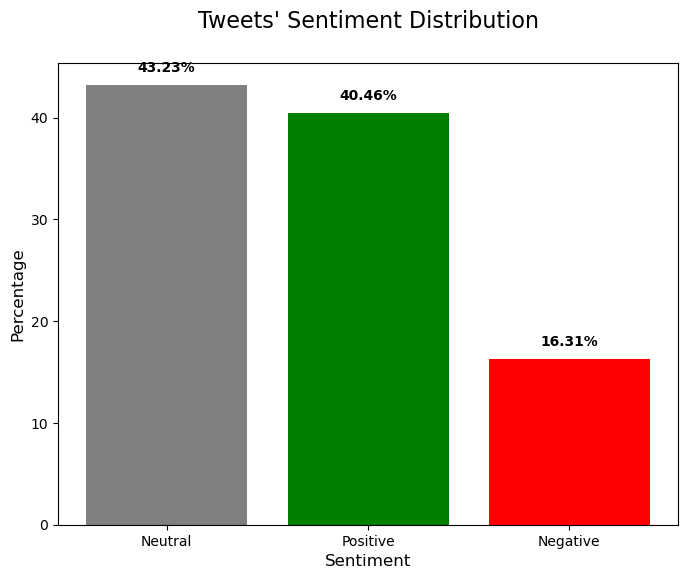

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the sentiment distribution in a DataFrame called 'df'
sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_dist.index, sentiment_dist, color=['grey', 'green', 'red'])

# Add percentage labels above the bars
for i, v in enumerate(sentiment_dist):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# Add title and labels
plt.title("Tweets' Sentiment Distribution\n", fontsize=16, color='black')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Percentage", fontsize=12)

# Show the plot
plt.show()


<Axes: ylabel='user_name'>

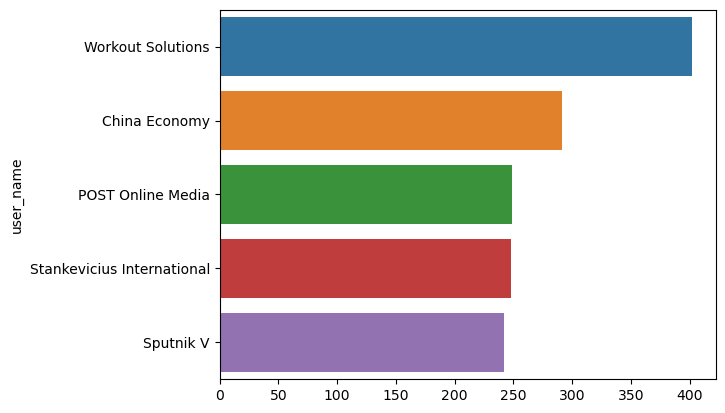

In [12]:
def top5AccountsBySentiment(sentiment):
    tweet = df.query("sentiment==@sentiment")
    top5 = tweet.groupby(by=["user_name"])['sentiment'].count().sort_values(ascending=False)[:5]
    return(top5)

neutral5 = top5AccountsBySentiment("Neutral")
sns.barplot(x = neutral5.values, y = neutral5.index)



<Axes: ylabel='user_name'>

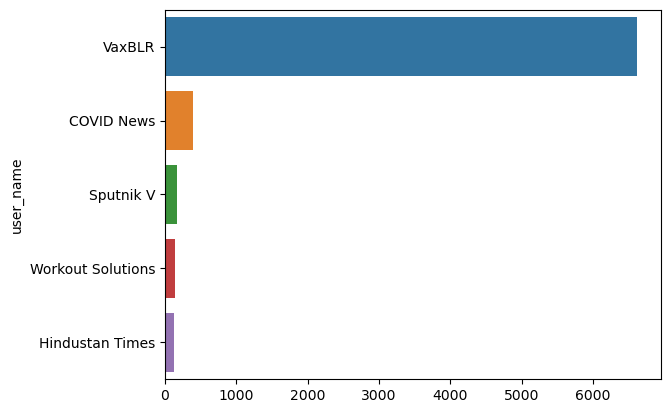

In [13]:
positive5 = top5AccountsBySentiment("Positive")
sns.barplot(x = positive5.values, y = positive5.index)


<Axes: ylabel='user_name'>

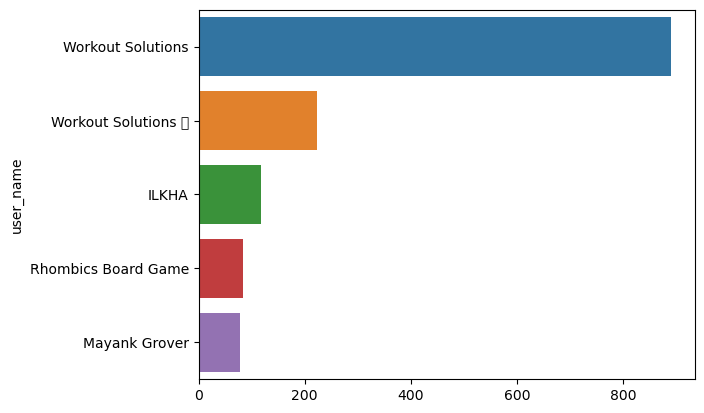

In [14]:
negative5 = top5AccountsBySentiment("Negative")
sns.barplot(x = negative5.values, y = negative5.index)

In [15]:
# BOW
vectorizer = CountVectorizer(ngram_range = (1,3))

tweet_positive = df[df['sentiment'] == 'Positive']['processed_tweet']
tweet_negative = df[df['sentiment'] == 'Negative']['processed_tweet']

positive_bow = vectorizer.fit_transform(tweet_positive)
negative_bow = vectorizer.fit_transform(tweet_negative)

feature_names = vectorizer.get_feature_names_out()

positive_word_frequencies = positive_bow.sum(axis = 0)
negative_word_frequencies = negative_bow.sum(axis = 0)

positive_word_freq_dict = dict(zip(feature_names, positive_word_frequencies.tolist()[0]))
negative_word_freq_dict = dict(zip(feature_names, negative_word_frequencies.tolist()[0]))

positive_wordcloud = WordCloud().generate_from_frequencies(positive_word_freq_dict)
negative_wordcloud = WordCloud().generate_from_frequencies(negative_word_freq_dict)

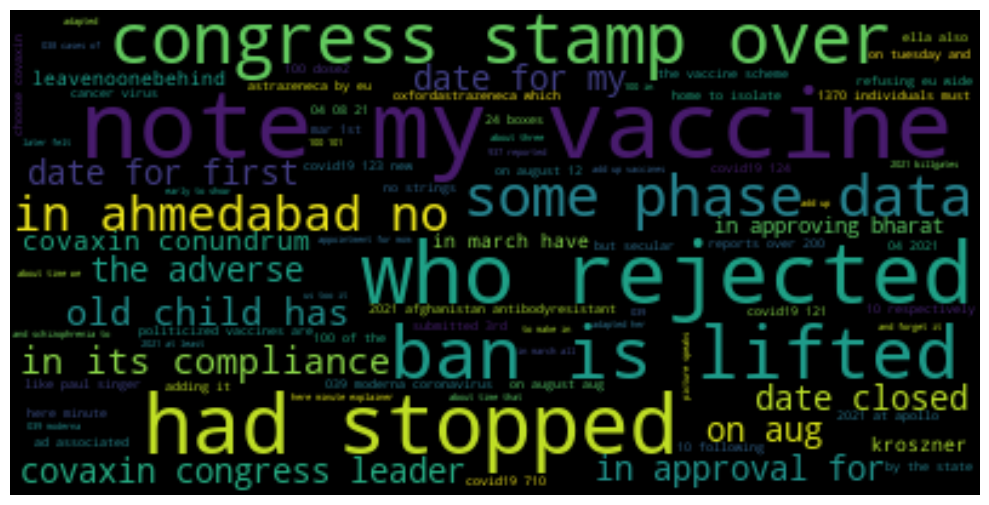

In [16]:
# BOW POSITIVE
plt.figure(figsize = (10,6))
plt.imshow(positive_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

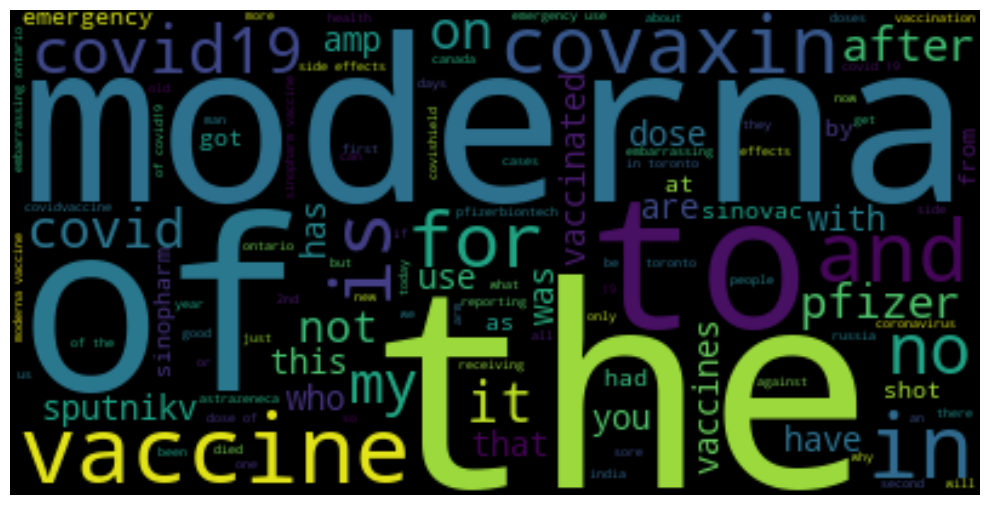

In [17]:
# BOW NEGATIVE
plt.figure(figsize = (10,6))
plt.imshow(negative_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range = (1,3))

tweet_positive = df[df['sentiment'] == 'Positive']['processed_tweet']
tweet_negative = df[df['sentiment'] == 'Negative']['processed_tweet']

positive_bow = vectorizer.fit_transform(tweet_positive)
negative_bow = vectorizer.fit_transform(tweet_negative)

feature_names = vectorizer.get_feature_names_out()

positive_word_frequencies = positive_bow.sum(axis = 0)
negative_word_frequencies = negative_bow.sum(axis = 0)

positive_word_freq_dict = dict(zip(feature_names, positive_word_frequencies.tolist()[0]))
negative_word_freq_dict = dict(zip(feature_names, negative_word_frequencies.tolist()[0]))

positive_wordcloud = WordCloud().generate_from_frequencies(positive_word_freq_dict)
negative_wordcloud = WordCloud().generate_from_frequencies(negative_word_freq_dict)

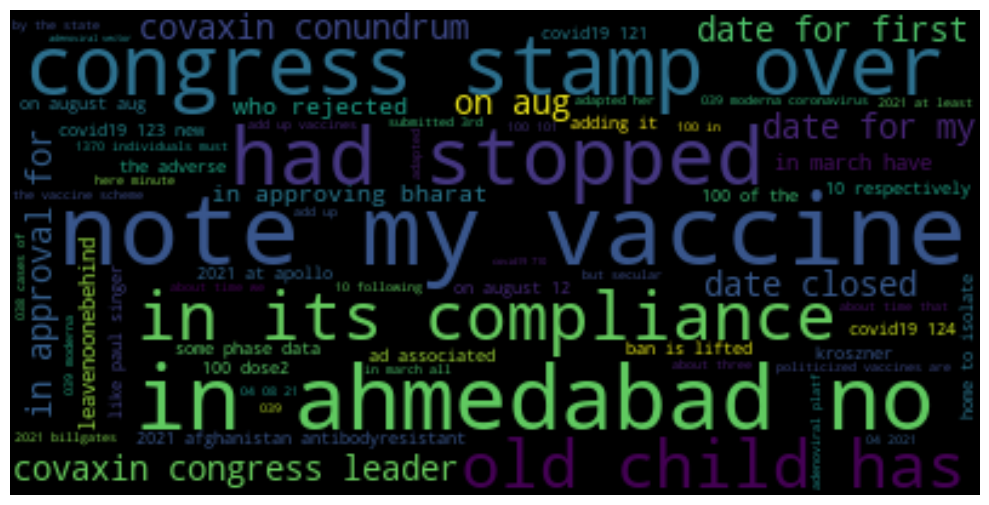

In [19]:
# TF-IDF Vectorizer - POSITIVE
plt.figure(figsize = (10,6))
plt.imshow(positive_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

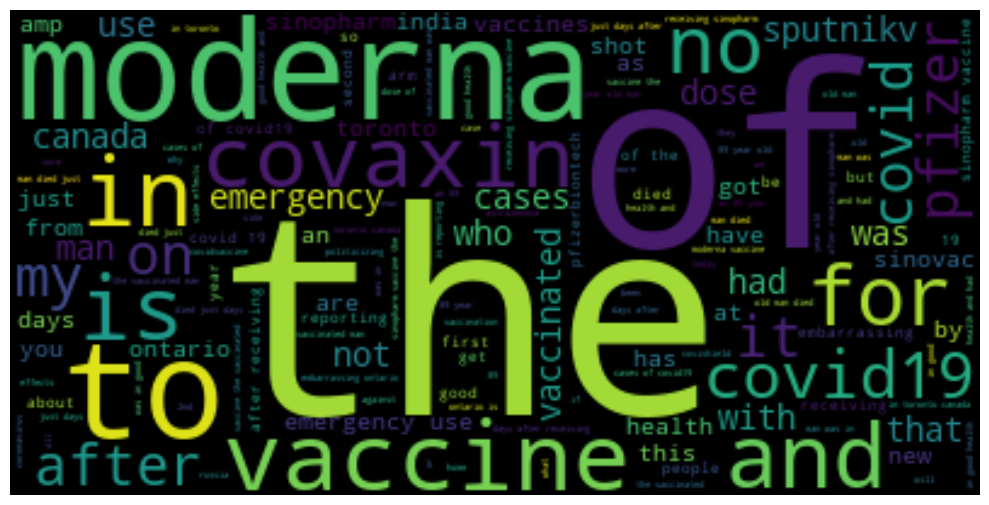

In [20]:
# TF-IDF Vectorizer - NEGATIVE
plt.figure(figsize = (10,6))
plt.imshow(negative_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

#### **Topic Modelling with BERTopic**
****

In [21]:
# Set TOKENIZERS_PARALLELISM to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"

vectorizer_model = CountVectorizer(ngram_range=(1, 5))

topic_model = BERTopic(nr_topics=5, language='english', vectorizer_model=vectorizer_model,
                       calculate_probabilities=True, verbose=True)

topics, probabilities = topic_model.fit_transform(tweet_positive.tolist())

Batches:   0%|          | 0/1468 [00:00<?, ?it/s]

2023-07-22 23:56:45,062 - BERTopic - Transformed documents to Embeddings
2023-07-22 23:57:56,397 - BERTopic - Reduced dimensionality
2023-07-23 00:17:20,675 - BERTopic - Clustered reduced embeddings
2023-07-23 00:17:41,243 - BERTopic - Reduced number of topics from 623 to 5


In [22]:
topic_model.visualize_barchart(top_n_topics = 5)

In [23]:
topic_model.visualize_topics()

In [24]:
topic_model.visualize_heatmap()

In [25]:
topic_model = BERTopic(nr_topics=5, language='english', vectorizer_model=vectorizer_model,
                       calculate_probabilities=True, verbose=True)

topics, probabilities = topic_model.fit_transform(tweet_negative.tolist())

Batches:   0%|          | 0/592 [00:00<?, ?it/s]

2023-07-23 00:19:59,401 - BERTopic - Transformed documents to Embeddings
2023-07-23 00:20:41,677 - BERTopic - Reduced dimensionality
2023-07-23 00:22:36,736 - BERTopic - Clustered reduced embeddings
2023-07-23 00:22:54,120 - BERTopic - Reduced number of topics from 280 to 5


In [26]:
topic_model.visualize_barchart(top_n_topics = 5)

In [27]:
topic_model.visualize_topics()

In [28]:
topic_model.visualize_heatmap()

In [29]:
# Set TOKENIZERS_PARALLELISM to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Get the topic-word matrix from BERTopic
topic_word_matrix = topic_model.get_topic_info()

# Extract the list of lists of topic keywords
topics_keywords = topic_word_matrix["Name"].apply(lambda x: x.split()).tolist()

# Create a Gensim Dictionary from the topic keywords
dictionary = Dictionary(topics_keywords)

# Create a Gensim Corpus from the topic keywords
corpus = [dictionary.doc2bow(topic) for topic in topics_keywords]

# Compute the coherence score using C_v coherence measure (can also try other coherence measures)
coherence_model = CoherenceModel(model=topic_model, texts=topics_keywords, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print the coherence score
print("Coherence Score:", coherence_score)

Coherence Score: 1.0


In [30]:
print(topic_word_matrix.columns)
topic_word_matrix.head()

Index(['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs'], dtype='object')


Topic  Count                                               Name  \
0     -1   7044                               -1_the_of_to_moderna   
1      0  11788                           0_the_moderna_vaccine_of   
2      1     67  1_california governor_governor_newsom_californ...   
3      2     16           2_in_protests_vaccinalpassport_greenpass   
4      3     11  3_greeksinart_eunotforme_eunotforme greeksinar...   

                                      Representation  \
0  [the, of, to, moderna, and, in, covaxin, vacci...   
1  [the, moderna, vaccine, of, to, in, and, is, c...   
2  [california governor, governor, newsom, califo...   
3  [in, protests, vaccinalpassport, greenpass, fr...   
4  [greeksinart, eunotforme, eunotforme greeksina...   

                                 Representative_Docs  
0  [my worry is the second dose we have seen mode...  
1  [an 89 year old man died just days after recei...  
2  [ where is california governor newsom who s be...  
3  [ demonstration protests in many cities in fra...  
4  [ eunotforme greeksinart who is the front of m...